Data Science Mini Project 2 - Students Performance

> This project uses two approaches: a Random Forest classifier and a Support Vector Machine Classifier (SVC) to predict the student performance using the grades and course interaction data collected from Moodle.


In [2]:
# importing necessary libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)
warnings.filterwarnings('ignore')

In [3]:
# loading the dataset into a pandas dataframe
data_path = "MP2_Data.csv"
df = pd.read_csv(data_path)

# getting the number of rows in the dataset
print("Size of the data: ", df.shape[0])
df.head()

Size of the data:  107


,ID,Week2_Quiz1,Week3_MP1,Week3_PR1,Week5_MP2,Week5_PR2,Week7_MP3,Week7_PR3,Week4_Quiz2,Week6_Quiz3,...,Week7_Stat3,Week8_Stat0,Week8_Stat1,Week8_Stat2,Week8_Stat3,Week9_Stat0,Week9_Stat1,Week9_Stat2,Week9_Stat3,Grade
0,ML-2020-1,5.00,15.0,5.0,16.09,5.00,21.88,5.0,5.00,5.0,...,0,5,4,0,4,8,6,1,0,4
1,ML-2020-2,3.33,15.0,5.0,17.83,5.00,22.27,5.0,4.00,5.0,...,8,5,2,0,0,25,3,2,5,4
2,ML-2020-3,1.67,13.0,5.0,15.22,5.00,27.05,2.5,5.00,5.0,...,0,8,2,0,0,9,0,1,0,3
3,ML-2020-4,2.50,14.0,5.0,10.00,5.00,31.02,5.0,3.13,5.0,...,4,10,0,0,0,7,6,0,0,3
4,ML-2020-6,0.00,15.0,5.0,12.17,4.93,15.91,5.0,4.67,5.0,...,6,8,5,1,1,5,3,1,0,2


Step 1: Data processing <br/>
  * Are there any missing values? <br/>
  * What are your features? <br/>
  * Are you keeping every feature? <br/> 


In [4]:
# checking if there are any null values for the columns
df.isnull().sum()

ID             0
Week2_Quiz1    0
Week3_MP1      0
Week3_PR1      0
Week5_MP2      0
Week5_PR2      0
Week7_MP3      0
Week7_PR3      0
Week4_Quiz2    0
Week6_Quiz3    0
Week8_Total    0
Week1_Stat0    0
Week1_Stat1    0
Week1_Stat2    0
Week1_Stat3    0
Week2_Stat0    0
Week2_Stat1    0
Week2_Stat2    0
Week2_Stat3    0
Week3_Stat0    0
Week3_Stat1    0
Week3_Stat2    0
Week3_Stat3    0
Week4_Stat0    0
Week4_Stat1    0
Week4_Stat2    0
Week4_Stat3    0
Week5_Stat0    0
Week5_Stat1    0
Week5_Stat2    0
Week5_Stat3    0
Week6_Stat0    0
Week6_Stat1    0
Week6_Stat2    0
Week6_Stat3    0
Week7_Stat0    0
Week7_Stat1    0
Week7_Stat2    0
Week7_Stat3    0
Week8_Stat0    0
Week8_Stat1    0
Week8_Stat2    0
Week8_Stat3    0
Week9_Stat0    0
Week9_Stat1    0
Week9_Stat2    0
Week9_Stat3    0
Grade          0
dtype: int64

In [5]:
# getting columns having varying values
columns_with_varying_values = []
original_columns = df.columns
for col in original_columns:
    if len(df[col].value_counts()) > 1:
        columns_with_varying_values.append(col)

# only including columns that have varying values
# After checking the values, the column Week1_Stat1 was found to have only zero
# values so removing the column by keeping only those columns with varying values
df = df[columns_with_varying_values]

In [6]:
# checking if the dataset is balanced
df['Grade'].value_counts()

0    48
4    24
3    17
5    13
2     5
Name: Grade, dtype: int64

In [7]:
feature_columns = [col for col in df.columns if col not in ['ID', 'Grade', 'is_train', 'Week8_Total']]

grade_columns = ["Week2_Quiz1", "Week3_MP1", "Week3_PR1", "Week4_Quiz2", "Week5_MP2", "Week5_PR2", "Week6_Quiz3", "Week7_MP3", "Week7_PR3"]

# Combining stat columns according to its type
stat0_cols = [col for col in feature_columns if col.split('_')[1]=='Stat0']
stat1_cols = [col for col in feature_columns if col.split('_')[1]=='Stat1']
stat2_cols = [col for col in feature_columns if col.split('_')[1]=='Stat2']
stat3_cols = [col for col in feature_columns if col.split('_')[1]=='Stat3']

df['stat0'] = df[stat0_cols].sum(axis=1)
df['stat1'] = df[stat1_cols].sum(axis=1)
df['stat2'] = df[stat2_cols].sum(axis=1)
df['stat3'] = df[stat3_cols].sum(axis=1)

filtered_feature_columns = grade_columns + ['stat0', 'stat1', 'stat2', 'stat3']
print(filtered_feature_columns)

['Week2_Quiz1', 'Week3_MP1', 'Week3_PR1', 'Week4_Quiz2', 'Week5_MP2', 'Week5_PR2', 'Week6_Quiz3', 'Week7_MP3', 'Week7_PR3', 'stat0', 'stat1', 'stat2', 'stat3']


Step 2: Training and Test Dataset


*   Divide your data in an appropriate proportion into training and test dataset.



In [8]:
# separating the train and test data rows
df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.80

train_df, test_df = df[df['is_train']==True], df[df['is_train']==False]

# checking the Grade value distribution in the training dataset
train_df['Grade'].value_counts()

0    41
4    19
3    16
5    10
2     5
Name: Grade, dtype: int64

In [9]:
# show number of observations in the train and test dataframes
print("Number of observations in the training data: ", train_df.shape[0])
print("Number of observations in the test data: ", test_df.shape[0])

Number of observations in the training data:  91
Number of observations in the test data:  16


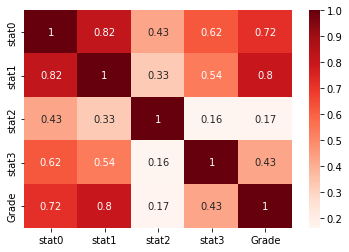

In [10]:
# checking the correlation of the stat columns with the grade column
cols_to_use = ['stat0', 'stat1', 'stat2', 'stat3', 'Grade']

sns.heatmap(df[cols_to_use].corr(), annot=True, cmap='Reds')
plt.show()

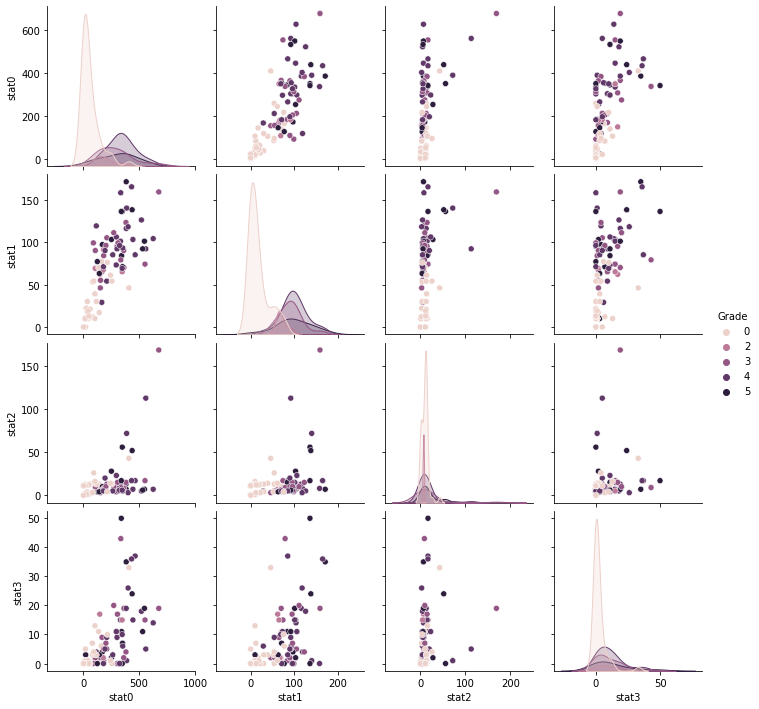

In [18]:
sns.pairplot(df[cols_to_use], hue="Grade")

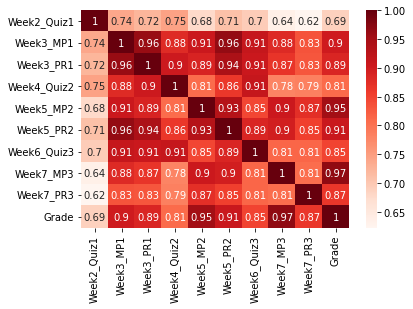

In [20]:
# checking the correlation of the grade columns with the final Grade column
cols_to_check = grade_columns + ['Grade']
sns.heatmap(df[cols_to_check].corr(), annot=True, cmap='Reds')
plt.show()

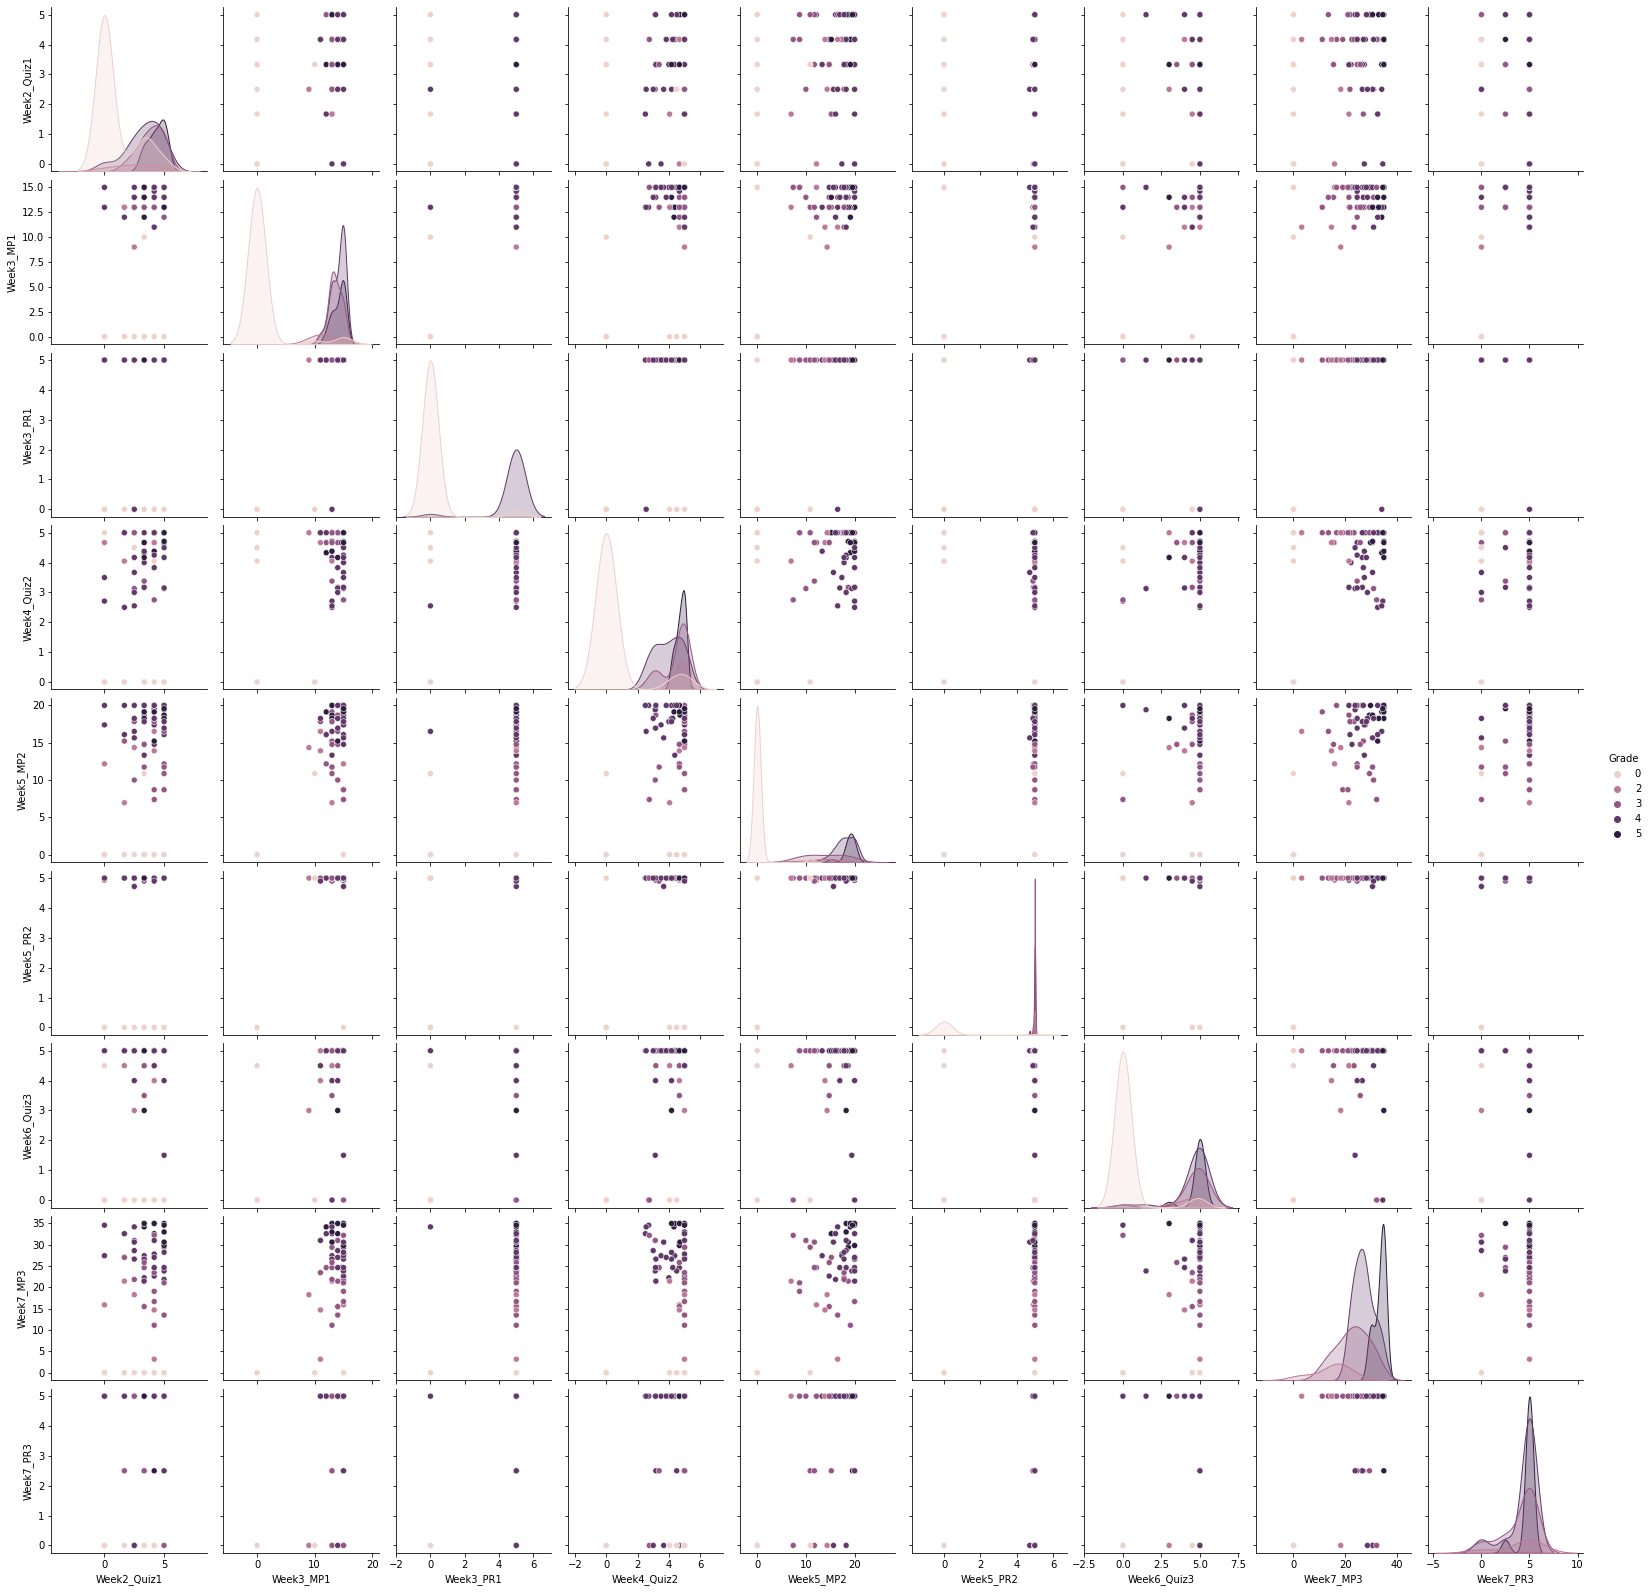

In [22]:
sns.pairplot(df[cols_to_check], hue="Grade")

In [12]:
y = train_df['Grade']

Step 3: Train the model

First approach: Using Random Forest Classifier

In [13]:
## First approach: Using random forest classifier 
## Using the feature importances property of random forest classifier to identify 
## the most important features and use these to train the model

# create a random forest classifier
random_forest_classifier = RandomForestClassifier(n_jobs=2, random_state=0)
random_forest_classifier.fit(train_df[filtered_feature_columns], y)

feature_importances_tuple =  sorted(list(zip(filtered_feature_columns, abs(random_forest_classifier.feature_importances_))), key=lambda x: x[1], reverse=True)
final_features = [col[0] for col in feature_importances_tuple if col[1] > 0.07]

# training the model using the filtered important features of the training data
random_forest_classifier.fit(train_df[final_features], y)

# using the trained classifier to predict for the tests dataset
predictions = random_forest_classifier.predict(test_df[final_features])
test_df['random_forest_predictions'] = predictions

Step 4: Performance Evaluation

In [14]:
# getting the prediction probabilities
random_forest_classifier.predict_proba(test_df[final_features])

array([[0.  , 0.  , 0.  , 0.09, 0.91],
       [0.01, 0.  , 0.13, 0.51, 0.35],
       [0.  , 0.02, 0.11, 0.4 , 0.47],
       [0.  , 0.04, 0.51, 0.43, 0.02],
       [0.83, 0.09, 0.08, 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.24, 0.7 , 0.02],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.04, 0.06, 0.9 ],
       [0.  , 0.04, 0.23, 0.37, 0.36],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.07, 0.15, 0.76, 0.02],
       [0.  , 0.04, 0.08, 0.79, 0.09],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ]])

In [15]:
# checking the predictions
pd.crosstab(test_df['Grade'], predictions, rownames=['Actual Grade'], colnames=['Predicted Grade'])

Predicted Grade,0,3,4,5
Actual Grade,,,,
0,7,0,0,0
3,0,0,1,0
4,0,1,4,0
5,0,0,0,3


In [16]:
# computing accuracy score for the model to evaluate the model performance
print(classification_report(test_df['Grade'], predictions))
print("Accuracy: ", accuracy_score(test_df['Grade'], predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         1
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00         3

    accuracy                           0.88        16
   macro avg       0.70      0.70      0.70        16
weighted avg       0.88      0.88      0.88        16

Accuracy:  0.875


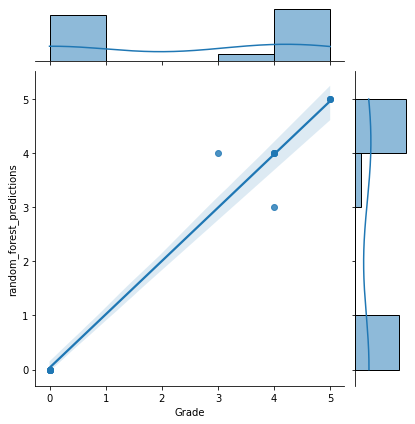

In [17]:
# plotting a joint plot with the Actual Grade on the X-axis and the predictions
# on the Y-axis.
plot = sns.jointplot(data=test_df, x="Grade", y="random_forest_predictions", kind="reg")

In [20]:
## Recursive feature elimination (RFE)
# testing out to check if the features gotten from RFE are better for model performance

from sklearn.feature_selection import RFE

random_forest_classifier2 = RandomForestClassifier(n_jobs=2, random_state=0)

rfe = RFE(random_forest_classifier2)

rfe.fit(train_df[filtered_feature_columns], y)

test_predictions = rfe.predict(test_df[filtered_feature_columns])
print("Selected features: %d" % rfe.n_features_)
print(rfe.support_)
selected_columns = [col for col in filtered_feature_columns if rfe.support_[filtered_feature_columns.index(col)]]
print(selected_columns)

print(classification_report(test_df['Grade'], test_predictions))
print(accuracy_score(test_df['Grade'], test_predictions))
rfe.predict_proba(test_df[filtered_feature_columns])
pd.crosstab(test_df['Grade'], predictions, rownames=['Actual Grade'], colnames=['Predicted Grade'])

Selected features: 6
[False  True False  True  True False False  True False  True  True False
 False]
['Week3_MP1', 'Week4_Quiz2', 'Week5_MP2', 'Week7_MP3', 'stat0', 'stat1']
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         1
           4       0.75      0.60      0.67         5
           5       0.75      1.00      0.86         3

    accuracy                           0.81        16
   macro avg       0.62      0.65      0.63        16
weighted avg       0.81      0.81      0.81        16

0.8125


Predicted Grade,0,3,4,5
Actual Grade,,,,
0,7,0,0,0
3,0,0,1,0
4,0,1,4,0
5,0,0,0,3


Second approach: Using Support Vector Machine Classifier (SVC)

In [19]:
## Second approach: Using Support Vector Machine Classifier
## Using the important features identified from the random forest process

from sklearn import svm
from sklearn.preprocessing import StandardScaler

# using StandardScaler to scale the values
scaler = StandardScaler()

# scaling the train and test sets with StandardScaler
X_train = scaler.fit_transform(train_df[final_features])
X_test = scaler.fit_transform(test_df[final_features])

## Using a Linear SVC
lin_clf = svm.LinearSVC()

# training the SVC on the training data
lin_clf.fit(X_train, y)
svc_predictions = lin_clf.predict(X_test)

test_df['svc_predictions'] = svc_predictions

In [20]:
# checking the predictions
pd.crosstab(test_df['Grade'], svc_predictions, rownames=['Actual Grade'], colnames=['Predicted Grade'])

Predicted Grade,0,3,4,5
Actual Grade,,,,
0,7,0,0,0
3,0,0,1,0
4,0,1,3,1
5,0,0,0,3


In [21]:
# computing the accuracy score to evaluate the model performance
print(classification_report(test_df['Grade'], svc_predictions))
print("Accuracy: ", accuracy_score(test_df['Grade'], svc_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         1
           4       0.75      0.60      0.67         5
           5       0.75      1.00      0.86         3

    accuracy                           0.81        16
   macro avg       0.62      0.65      0.63        16
weighted avg       0.81      0.81      0.81        16

Accuracy:  0.8125


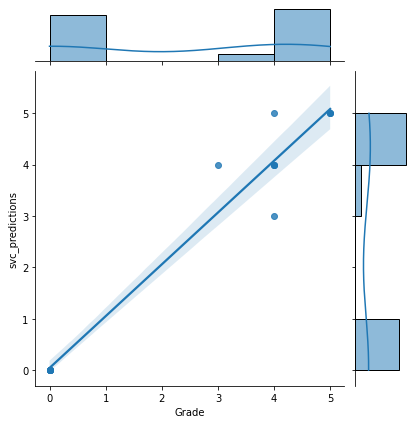

In [22]:
# plotting a joint plot with the Actual Grade on the X-axis and the predictions
# on the Y-axis.
sns.jointplot(data=test_df, x="Grade", y="svc_predictions", kind="reg")

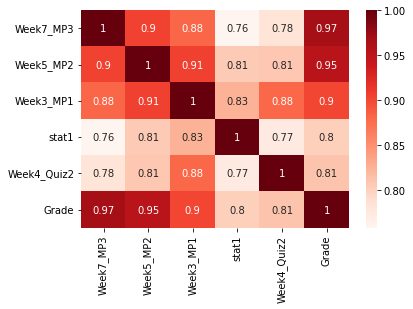

In [24]:
# plot the correlation matrix of the used columns with the grade column
cols_to_check = final_features + ["Grade"]
sns.heatmap(df[cols_to_check].corr(), annot=True, cmap='Reds')
plt.show()

Step 5: Important features

In [23]:
print("Important features to be used: ", final_features)
sorted_feature_importance_scores = sorted(feature_importances_tuple, key=lambda x: x[1], reverse=True)
print(pd.DataFrame([{'feature': col[0], "score": col[1]} for col in sorted_feature_importance_scores]))
top_three_features = [col[0] for col in sorted_feature_importance_scores][:3]

print("\n\nThe top three features are: ", top_three_features)

Important features to be used:  ['Week7_MP3', 'Week5_MP2', 'Week3_MP1', 'stat1', 'Week4_Quiz2']
        feature     score
0     Week7_MP3  0.197085
1     Week5_MP2  0.185397
2     Week3_MP1  0.126210
3         stat1  0.080433
4   Week4_Quiz2  0.077068
5   Week6_Quiz3  0.054628
6         stat0  0.054330
7     Week3_PR1  0.045725
8     Week5_PR2  0.043018
9     Week7_PR3  0.039120
10        stat3  0.035273
11  Week2_Quiz1  0.033041
12        stat2  0.028673


The top three features are:  ['Week7_MP3', 'Week5_MP2', 'Week3_MP1']
